In [2]:
import torchaudio
import torch
from importlib import reload
from diffwave.preprocess import transform
import diffwave
reload(diffwave.preprocess)
import matplotlib.pyplot as plt

data_dir = '/Users/lukgar/Desktop/exjobb/datasets/LJSpeech-1.1/wavs/'
wavname = 'LJ001-0005'
filename = data_dir + wavname + '.wav'

In [3]:
from IPython.display import Audio, display
def play_audio(waveform, sample_rate):
  waveform = waveform.cpu().numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

In [6]:
# Load audio file
audio, sr = torchaudio.load(filename)
# Play audio file
play_audio(audio, sr)

In [7]:
# downsample to 11025 Hz
sr2 = 11025
audio = torchaudio.transforms.Resample(sr, sr2)(audio)

# Play audio file
play_audio(audio, sr2)

# save
torchaudio.save(f'{wavname}_11025.wav', audio, sr2)

In [10]:
# Downsample all wav files in wavs11025 to 11025 hz
import os

for file in os.listdir('wavs11025'):
    if file.endswith('.wav'):
        audio, sr = torchaudio.load(f'wavs11025/{file}')
        audio = torchaudio.transforms.Resample(sr, sr2)(audio)

        torchaudio.save(f'wavs11025/{file}', audio, sr2, bits_per_sample=16)


torch.Size([1, 40, 222])
torch.Size([1, 56655]) 11025


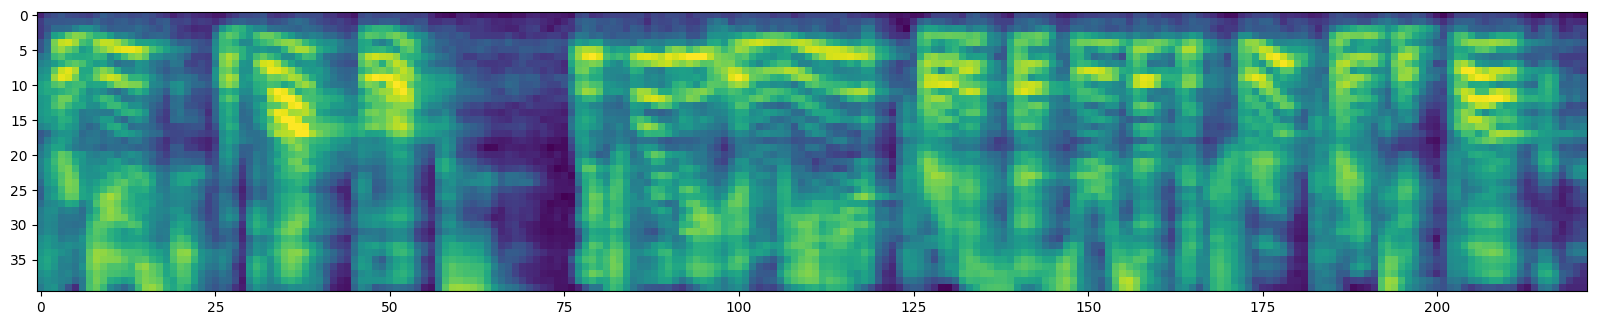

In [73]:
filename_2 = f'{wavname}_11025.wav'
spec = transform(filename_2, save=False)
spectrogram = spec.view(1, *spec.shape)

print(spectrogram.shape) # small: (1, 40, 222), big: (1, 80, 443) (original)
print(audio.shape, sr2)

plt.imshow(spectrogram[0].numpy());

In [74]:
from diffwave.params import params
print(params)
# hop_samples = 256
# 256 * 443 = 113408

{'batch_size': 16, 'learning_rate': 0.0002, 'max_grad_norm': None, 'sample_rate': 11025, 'n_mels': 40, 'n_fft': 2048, 'hop_samples': 256, 'crop_mel_frames': 62, 'residual_layers': 1, 'residual_channels': 64, 'dilation_cycle_length': 10, 'unconditional': False, 'noise_schedule': [0.0001, 0.0011183673469387756, 0.002136734693877551, 0.0031551020408163264, 0.004173469387755102, 0.005191836734693878, 0.006210204081632653, 0.007228571428571429, 0.008246938775510203, 0.009265306122448979, 0.010283673469387754, 0.01130204081632653, 0.012320408163265305, 0.013338775510204081, 0.014357142857142857, 0.015375510204081632, 0.016393877551020408, 0.017412244897959183, 0.01843061224489796, 0.019448979591836734, 0.02046734693877551, 0.021485714285714285, 0.02250408163265306, 0.023522448979591836, 0.02454081632653061, 0.025559183673469387, 0.026577551020408163, 0.027595918367346938, 0.028614285714285714, 0.02963265306122449, 0.030651020408163265, 0.031669387755102044, 0.03268775510204082, 0.03370612244

In [75]:
from diffwave.model import DiffWave

In [76]:
model = DiffWave(params)

In [80]:
from torchinfo import summary
spec_shape = tuple(spectrogram.shape)
audio_shape = (1, params.hop_samples * spec_shape[-1]) # Should be 113408? Padding?
step_shape = (1,)

print(spec_shape)
print(audio_shape)
print(audio.shape)

(1, 40, 222)
(1, 56832)
torch.Size([1, 56655])


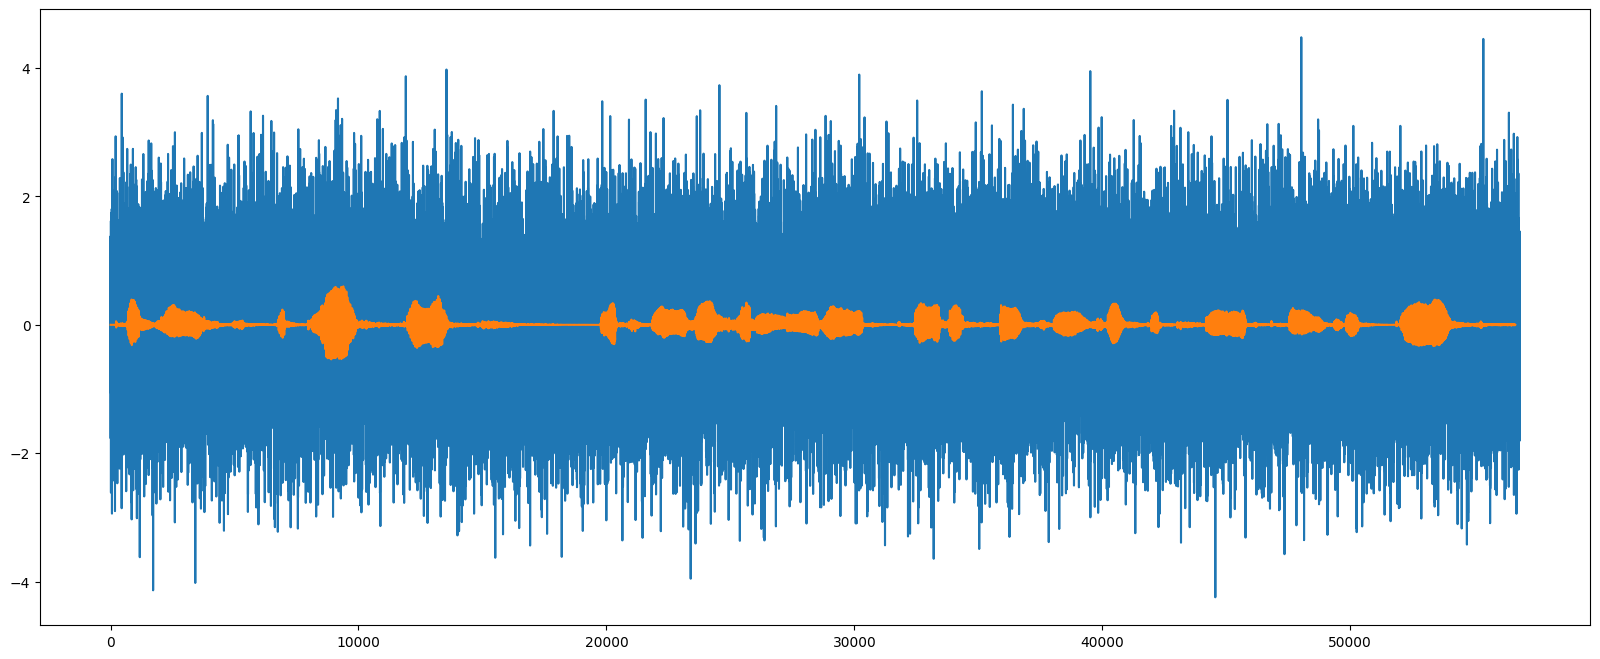

In [81]:
audio_noise = torch.randn(audio_shape, device=torch.device('cpu'))
plt.plot(audio_noise[0].numpy());
plt.plot(audio[0].numpy());

# Adjust plot size
plt.rcParams['figure.figsize'] = [20, 8]

In [82]:
summary(model, [audio_shape, (1,), spec_shape], depth=2)


Layer (type:depth-idx)                   Output Shape              Param #
DiffWave                                 [1, 1, 56832]             --
├─Conv1d: 1-1                            [1, 64, 56832]            128
├─DiffusionEmbedding: 1-2                [1, 512]                  --
│    └─Linear: 2-1                       [1, 512]                  66,048
│    └─Linear: 2-2                       [1, 512]                  262,656
├─SpectrogramUpsampler: 1-3              [1, 40, 56832]            --
│    └─ConvTranspose2d: 2-3              [1, 1, 40, 3552]          97
│    └─ConvTranspose2d: 2-4              [1, 1, 40, 56832]         97
├─ModuleList: 1-4                        --                        --
│    └─ResidualBlock: 2-5                [1, 64, 56832]            71,104
├─Conv1d: 1-5                            [1, 64, 56832]            4,160
├─Conv1d: 1-6                            [1, 1, 56832]             65
Total params: 404,355
Trainable params: 404,355
Non-trainable params

In [83]:
# Do one forward pass
t = torch.tensor([49])
pred_audio = model(audio_noise, t, spectrogram)

In [84]:
pred_audio[0,0,:].shape


torch.Size([56832])

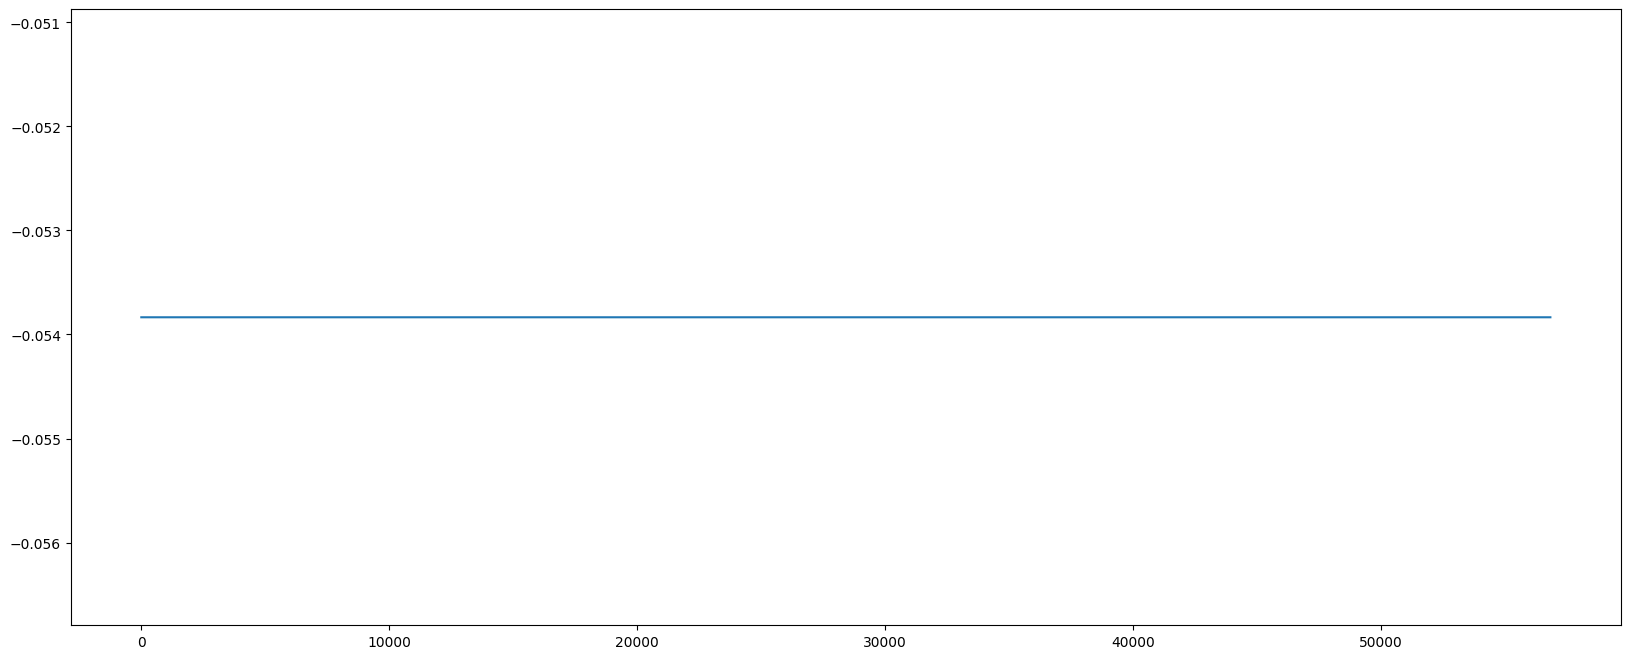

In [85]:
plt.plot(pred_audio[0,0,:].detach().numpy());

In [ ]:
# TODO:
# Set up training in a docker container - use template
# Should I try to use smaller spectrograms and audio files? yez

In [93]:
torch.cuda.device_count()

0